In [2]:
import tensorflow as tf
#import keras
from tensorflow import lite

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50,inception_v3,nasnet
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from IPython.display import clear_output
from tensorflow import keras
import time
import datetime

import shutil

from tensorflow.compat.v1 import ConfigProto,InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [2]:
keras.backend.clear_session()
print(tf.__version__)

2.0.0


In [3]:
print('number of train samples')
print(len(os.listdir('../input/datatree/train/nv')))
print(len(os.listdir('../input/datatree/train/mel')))
print(len(os.listdir('../input/datatree/train/bkl')))
print(len(os.listdir('../input/datatree/train/bcc')))
print(len(os.listdir('../input/datatree/train/akiec')))
print(len(os.listdir('../input/datatree/train/vasc')))
print(len(os.listdir('../input/datatree/train/df')))
print(len(os.listdir('../input/datatree/train/nod')))

number of train samples
4023
3895
3855
3610
3990
3490
2810
196


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

x_train = train_datagen.flow_from_directory(
    directory=r'../input/datatree/train/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=True,
    seed=42
)
train_generator = x_train
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weights = dict(enumerate(class_weights))
print("train_generator class_weights =",  class_weights)

validation_datagen = ImageDataGenerator(rescale=1./255)

x_validation = validation_datagen.flow_from_directory(
    directory=r'../input/datatree/validation/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=True,
    seed=42
)
validation_generator = x_validation
class_weights_val = class_weight.compute_class_weight('balanced', np.unique(validation_generator.classes), validation_generator.classes)
class_weights_val = dict(enumerate(class_weights_val))
class_weights_val
print("val_generator class_weights =",  class_weights_val)

test_datagen = ImageDataGenerator(rescale=1./255)

x_test = test_datagen.flow_from_directory(
    directory=r'../input/datatree/test/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_generator = x_test

num_train_samples = train_generator.n
num_val_samples = validation_generator.n
train_batch_size = 256
val_batch_size = 256


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
print(train_steps)
print(val_steps)

Found 25869 images belonging to 8 classes.
train_generator class_weights = {0: 0.8104323308270677, 1: 0.8957409972299168, 2: 0.8388132295719845, 3: 1.150756227758007, 4: 0.830198973042362, 5: 16.498086734693878, 6: 0.8037844891871737, 7: 0.9265401146131805}
Found 2068 images belonging to 8 classes.
val_generator class_weights = {0: 3.976923076923077, 1: 2.534313725490196, 2: 1.1803652968036529, 3: 11.23913043478261, 4: 1.1644144144144144, 5: 3.801470588235294, 6: 0.19276659209545116, 7: 9.232142857142858}
Found 2068 images belonging to 8 classes.
102.0
9.0


(224, 224, 3)


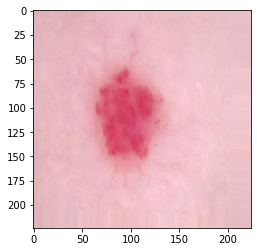

In [5]:
p = x_train.next()
print((p[0][0]).shape)
(plt.imshow(p[0][0][:,:,:]) )

In [6]:
lr =0.0001
def create_nasnet_model2(n_classes=8,learning_rate=lr):
    raw_model = nasnet.NASNetMobile(include_top=False,input_shape=(224,224,3), weights='imagenet') 
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    #for layer in raw_model.layers:
    #    layer.trainable = False
    full_model = Sequential()
    full_model.add(raw_model)
    full_model.add(GlobalAveragePooling2D())
    full_model.add(Dropout(0.2))
    full_model.add(Dense(512,activation='relu'))
    full_model.add(Dropout(0.1))
    full_model.add(Dense(8, activation = 'softmax'))
    full_model.compile(Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    full_model.summary()
    return full_model

#model = create_inception_model2(n_classes=15,learning_rate=lr)

In [7]:
keras.backend.clear_session()

model = create_nasnet_model2(n_classes=8,learning_rate=lr)
#model = inception_model_t1(n_classes=7, learning_rate=lr)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               541184    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4104      
Total params: 4,815,004
Trainable params: 4,778,266
Non-trainable params: 36,738
_________________________________________

In [8]:
#Reduce LR on plateau conditioned on metric `val_acc` which is not available. 
#Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

filepath = "../outputN/weights_part1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max',save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_generator, steps_per_epoch=train_steps, 
                            validation_data=validation_generator,
                            validation_steps=val_steps,
                            epochs=100, verbose=1,
                            class_weight = class_weights,
                            shuffle=False,  
                            callbacks=callbacks_list)

Epoch 1/100
101/102 [============================>.] - ETA: 0s - loss: 1.5306 - accuracy: 0.4226

/home/hamza/anaconda3/envs/tf/lib/python3.7/site-packages/PIL/Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)



Epoch 00001: val_accuracy improved from -inf to 0.63194, saving model to ../outputN/weights_part1.h5
102/102 [==============================] - 77s 752ms/step - loss: 1.5260 - accuracy: 0.4237 - val_loss: 1.1219 - val_accuracy: 0.6319
Epoch 2/100
101/102 [============================>.] - ETA: 0s - loss: 0.7959 - accuracy: 0.6631
Epoch 00002: val_accuracy improved from 0.63194 to 0.65278, saving model to ../outputN/weights_part1.h5
102/102 [==============================] - 71s 697ms/step - loss: 0.7949 - accuracy: 0.6624 - val_loss: 0.9771 - val_accuracy: 0.6528
Epoch 3/100
101/102 [============================>.] - ETA: 0s - loss: 0.6091 - accuracy: 0.7364
Epoch 00003: val_accuracy improved from 0.65278 to 0.65625, saving model to ../outputN/weights_part1.h5
102/102 [==============================] - 72s 706ms/step - loss: 0.6063 - accuracy: 0.7381 - val_loss: 1.0180 - val_accuracy: 0.6562
Epoch 4/100
101/102 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.79

In [9]:
keras_model = "../outputN/SkinCancer.pb"
keras.models.save_model(model,keras_model)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../outputN/SkinCancer.pb/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


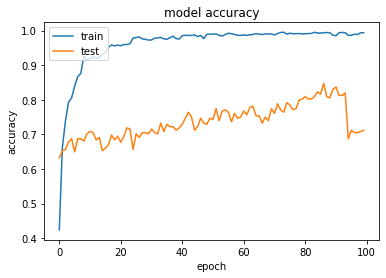

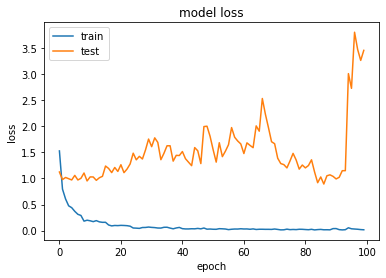

In [12]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
keras.backend.clear_session()
converter = tf.lite.TFLiteConverter.from_saved_model(keras_model)
tflite_model = converter.convert()
open("../outputN/converted_model.tflite", "wb").write(tflite_model)